# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
!pip install torchinfo

In [3]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [4]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:00<00:00, 124031811.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117379548.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 53805929.92it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17904632.30it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Визуализируйте несколько картинок с соответствующими метками из датасета.

Размер картинки:torch.Size([1, 28, 28])


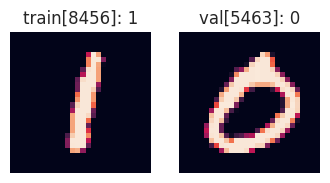

In [5]:
# берем 2 рандомных индекса
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off");

Создайте генераторы батчей.

In [6]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [7]:
simple_cnn1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(simple_cnn1, input_size=(1, 1, 28, 28))

simple_cnn2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4732, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10),
).to(device)

summary(simple_cnn2, input_size=(1, 1, 28, 28))

simple_cnn3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(simple_cnn3, input_size=(1, 1, 28, 28))

simple_cnn4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(simple_cnn4, input_size=(1, 1, 28, 28))

simple_cnn0 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4732, out_features=10),
).to(device)

summary(simple_cnn0, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 26, 26]           280
├─MaxPool2d: 1-2                         [1, 28, 13, 13]           --
├─ReLU: 1-3                              [1, 28, 13, 13]           --
├─Flatten: 1-4                           [1, 4732]                 --
├─Linear: 1-5                            [1, 10]                   47,330
Total params: 47,610
Trainable params: 47,610
Non-trainable params: 0
Total mult-adds (M): 0.24
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.19
Estimated Total Size (MB): 0.35

In [8]:
# добавим все нейросети в один массив
simples_knn = [simple_cnn0, simple_cnn1, simple_cnn2, simple_cnn3, simple_cnn4]

In [9]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [10]:
# Кросс-энтропия - общепринятый лосс для классификации
criterion = nn.CrossEntropyLoss()
history_knn = []
simples = ["simple_cnn.pth", "simple_cnn2.pth", "simple_cnn3.pth", "simple_cnn4.pth", "simple_cnn5.pth"]
for i in range(5):
  simple_cnn = simples_knn[i]
  simple = simples[i]
  optimizer = torch.optim.Adam(simple_cnn.parameters())
  history_cnn_temp = train(
      simple_cnn,
      criterion,
      optimizer,
      train_batch_gen,
      val_batch_gen,
      num_epochs=25,
  )
  # Сохраняем веса модели в файл
  torch.save(simple_cnn.state_dict(), simple)
  history_knn.append(history_cnn_temp)

Epoch 25 of 25 took 9.925 s
  training loss: 	0.004008
  validation loss: 	0.042782
  training accuracy: 			99.87 %
  validation accuracy: 			99.14 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

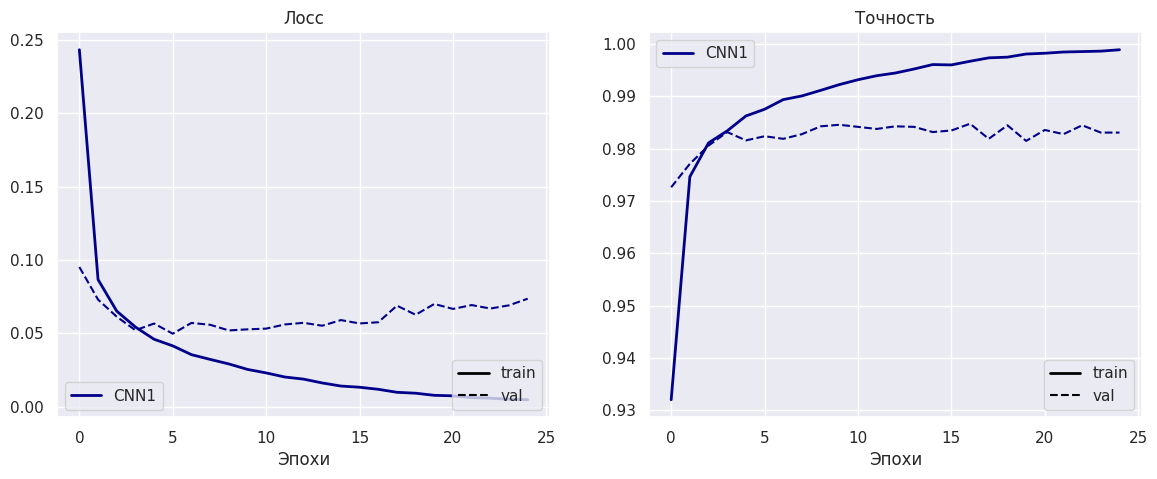

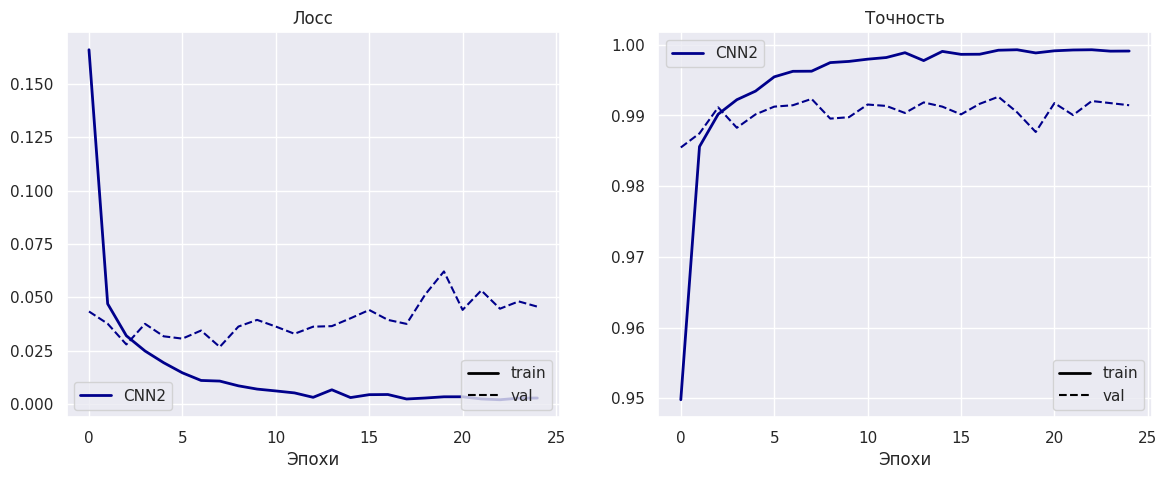

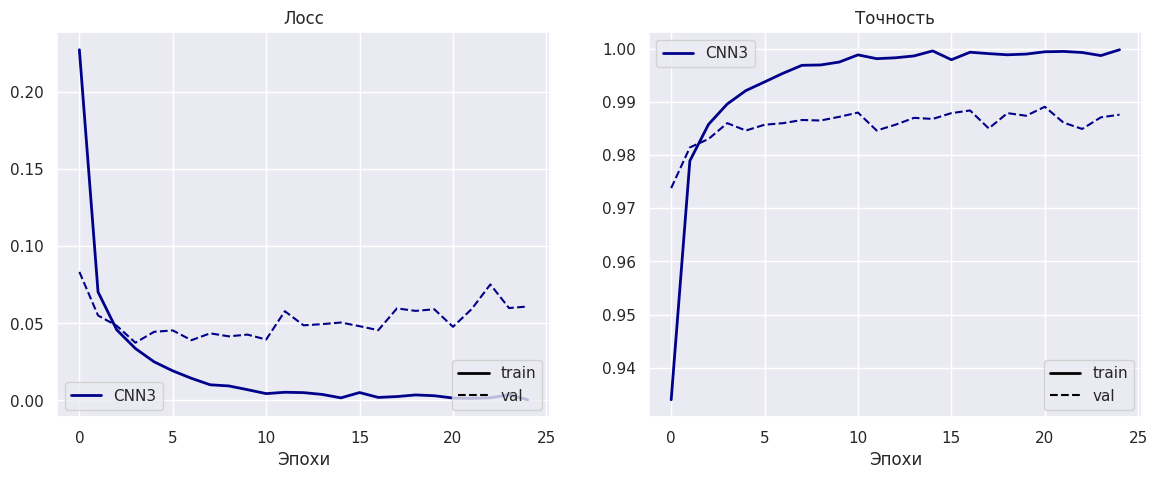

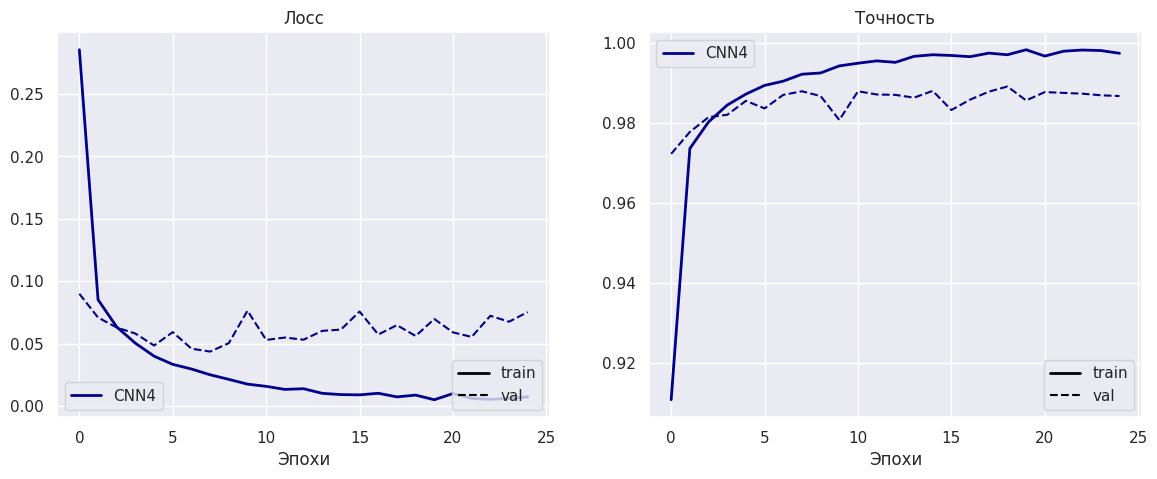

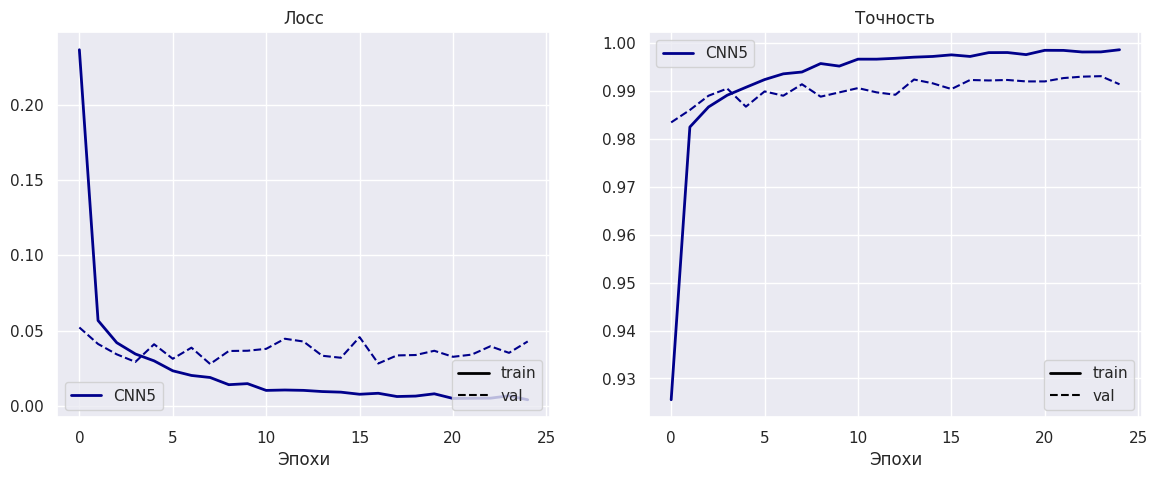

In [11]:
plot_histories([history_knn[0]], ["CNN1"])
plot_histories([history_knn[1]], ["CNN2"])
plot_histories([history_knn[2]], ["CNN3"])
plot_histories([history_knn[3]], ["CNN4"])
plot_histories([history_knn[4]], ["CNN5"])

In [12]:
names = ['CNN1', 'CNN2', 'CNN3', 'CNN4', 'CNN5']
print('Names        train                val')
for i in range(5):
  print(names[i], ':', history_knn[i]['acc']['train'][24], ' ', history_knn[i]['acc']['val'][24])


Names        train                val
CNN1 : 0.9989172441364605   0.9830812101910829
CNN2 : 0.9991004797441365   0.9914410828025477
CNN3 : 0.9999000533049041   0.9876592356687898
CNN4 : 0.9973514125799574   0.9866640127388535
CNN5 : 0.9986507196162047   0.9914410828025477


Как видно из таблицы и графиков лучше всего себя показали KNN2 и KNN5, тоесть нейросети с 2 и 4 сверточными уровнями


Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:**
* Все модели показали очень хорошие результаты, дастигнув точности выше 98% на тестовых данных
* Хуже всего себя показали совссем легкие нейросети имеющие только 1 сверточный или линейный слой
* Все модели показали высокую скорость обучения и вышли на плато на тестовых данных не позже чем через 5 эпох
* Увеличение количества слоев не гарантирует улучшение качества модели, так модель с 3 сверточными слоями показала себя хужже чем с 2, а сеть с 4 слоями хоть и хорошо себя показала, но не дала резельтат отличающийся от м второй модели

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

In [13]:
simple_cnn0 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(simple_cnn0, input_size=(1, 1, 28, 28))

simple_cnn1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(simple_cnn1, input_size=(1, 1, 28, 28))

simple_cnn2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(simple_cnn2, input_size=(1, 1, 28, 28))

simple_cnn3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(simple_cnn3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 24, 24]           728
├─MaxPool2d: 1-2                         [1, 28, 12, 12]           --
├─ReLU: 1-3                              [1, 28, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 8, 8]             44,864
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 310,562
Trainable params: 310,562
Non-trainable params: 0
Total mult-adds (M): 3.56
Input size (MB): 0.00
Forward/backward pass 

In [14]:
simples_knn = [simple_cnn0, simple_cnn1, simple_cnn2, simple_cnn3]

Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

In [15]:
# Кросс-энтропия - общепринятый лосс для классификации
criterion = nn.CrossEntropyLoss()
history_knn = []
simples = ["simple_cnn.pth", "simple_cnn2.pth", "simple_cnn3.pth", "simple_cnn4.pth", "simple_cnn5.pth"]
for i in range(4):
  simple_cnn = simples_knn[i]
  simple = simples[i]
  optimizer = torch.optim.Adam(simple_cnn.parameters())
  history_cnn_temp = train(
      simple_cnn,
      criterion,
      optimizer,
      train_batch_gen,
      val_batch_gen,
      num_epochs=25,
  )
  # Сохраняем веса модели в файл
  torch.save(simple_cnn.state_dict(), simple)
  history_knn.append(history_cnn_temp)

Epoch 25 of 25 took 9.706 s
  training loss: 	0.002853
  validation loss: 	0.046945
  training accuracy: 			99.93 %
  validation accuracy: 			99.24 %


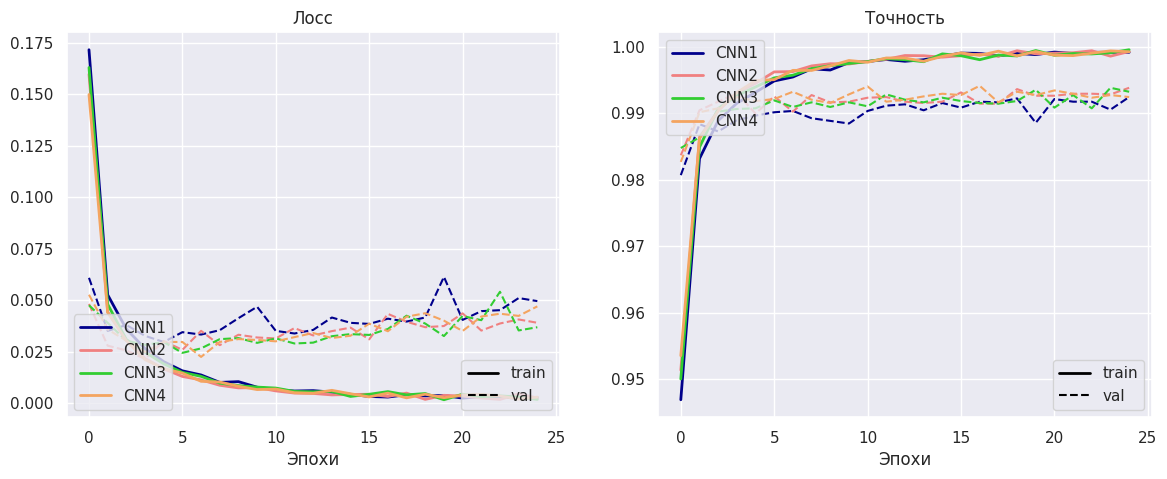

In [16]:
plot_histories(history_knn, ["CNN1", "CNN2", "CNN3", "CNN4"])

In [17]:
names = ['CNN1', 'CNN2', 'CNN3', 'CNN4']
print('Names        train                val')
for i in range(4):
  print(names[i], ':', history_knn[i]['acc']['train'][24], ' ', history_knn[i]['acc']['val'][24])

Names        train                val
CNN1 : 0.9991671108742004   0.9924363057324841
CNN2 : 0.9992837153518124   0.9938296178343949
CNN3 : 0.9995502398720683   0.9932324840764332
CNN4 : 0.9992503997867804   0.9924363057324841


Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:**
* В случае обучения на gpu размеры ядер не оказывают влияние на скорость обучения
* Размеры ядер не значительно влияют на результаты обучения, но во время всех опытов лучшие реультаты показывала нейросеть с размерами ядра 3 на первом слое и 5 на втором

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

Лучше всего себя показала модель с двумя сверточными слоями и ядрами 3, 5.

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [18]:
val_batch = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), shuffle = False)

In [20]:
accuracy_for_classes = []
wrong_predictions = []
for x, y in val_batch:
    x = x.to(device)
    y = y.to(device)
    y_pred = simple_cnn2(x).max(1)[1].detach()
    for num in range(10):
      wrong_predictions += list(zip(x[(y == num) & (y_pred != num)],
                              y[(y == num) & (y_pred != num)],
                              y_pred[(y == num) & (y_pred != num)]))
      accuracy_for_classes.append([len(y_pred[(y == num) & (y_pred == num)]) / len(y[y == num]), len(y[y == num])])

In [32]:
print("Number    Accuracy    Number of images ")
for cls in range(10):
  print(cls, f":        {accuracy_for_classes[cls][0]:.4f}        ", accuracy_for_classes[cls][1])

Number    Accuracy    Number of images 
0 :        0.9990         980
1 :        0.9965         1135
2 :        0.9942         1032
3 :        0.9970         1010
4 :        0.9949         982
5 :        0.9832         892
6 :        0.9916         958
7 :        0.9903         1028
8 :        0.9969         974
9 :        0.9871         1009


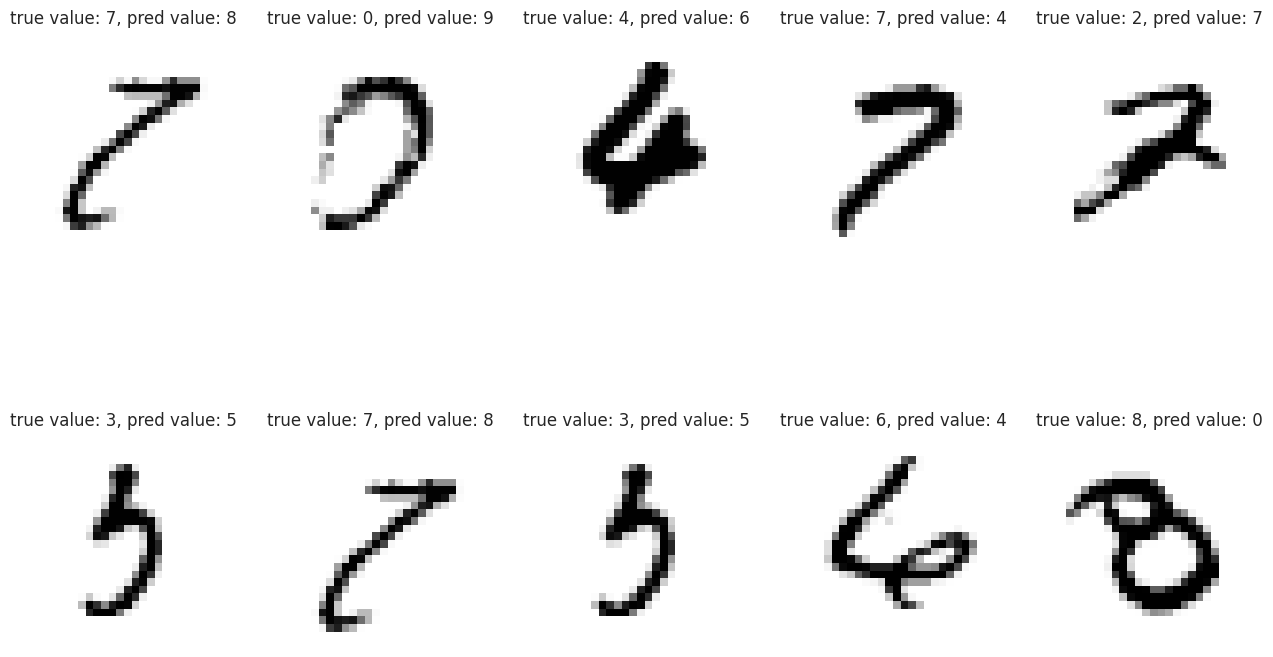

In [22]:
idx = np.random.randint(0, len(wrong_predictions), 10)
plt.figure(figsize=(16, 20))
for i, index in enumerate(idx):
  plt.subplot(4, 5, i + 1)
  plt.imshow(wrong_predictions[index][0].cpu().permute(1, 2, 0), cmap="Greys")
  plt.title(f"true value: {wrong_predictions[index][1]}, pred value: {wrong_predictions[index][2]}")
  plt.axis("off")

**Ответ:**
* Как видно из приведенной статистики точность по классам заметно отличается, так самым сложными для распознования оказались 5 и 9, на остальных же классах нейросеть показала точность выше 99%. Самыми легкими для распознования оказались 0, на этом классе нейросеть ошибилась только один раз.
* Неверно классифицированные картинки представляют собой ужасно написанные цифры, которые даже живой человек не всегда может однозначно распознать.

**Вывод по всей задаче:**
* Несмотря на использование достаточно простых моделей, все они показали очень хорошие результаты. Это свидетельствует, что нейросети хорошо справляются с классификацией простых изображений
* Даже при обучении таких простых моделей важно использовать gpu, а не cpu так как это позволяет на порядки ускорить процесс обучения

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

In [33]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

In [35]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 35.39 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


In [36]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [37]:
# подключим Google Drive
from google.colab import drive

drive.mount("/drive")

# пути к нужным папкам в Drive
content_path = "/drive/MyDrive/content"
style_path = "/drive/MyDrive/style"

# очистим предыдущие картинки, скопируем новые
!rm -r data/content-images
!mkdir data/content-images
!cp -a /$content_path/. data/content-images/

!rm -r data/style-images
!mkdir data/style-images
!cp -a /$style_path/. data/style-images/

Mounted at /drive


In [38]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 135MB/s]


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=1294683734016.0000, content_loss=      0.0000, style loss=1294670760000.0000, tv loss=12952289.0000
L-BFGS | iteration: 100, total loss=5072787456.0000, content_loss=1057818652.3438, style loss=3995768906.2500, tv loss=19200212.0000
L-BFGS | iteration: 200, total loss=2319324416.0000, content_loss=1001703710.9375, style loss=1297366289.0625, tv loss=20254576.0000
L-BFGS | iteration: 300, total loss=1781331584.0000, content_loss=950499804.6875, style loss=810502324.2188, tv loss=20329512.0000
L-BFGS | iteration: 400, total loss=1592621184.0000, content_loss=915551074.2188, style loss=656629160.1562, tv loss=20440944.0000
L-BFGS | iteration: 500, total loss=1492446976.0000, content_loss=892208398.4375, style loss=579718417.9688, tv loss=20520176.0000
L-BFGS | iteration: 600, total loss=1430227072.0000, content_loss=874875292.9688, style loss=534766054.6875, tv loss=20585788.0000
L-BFGS | iteration: 700, total 

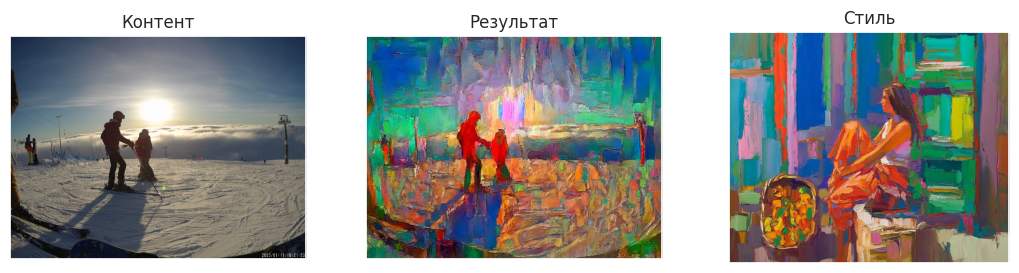

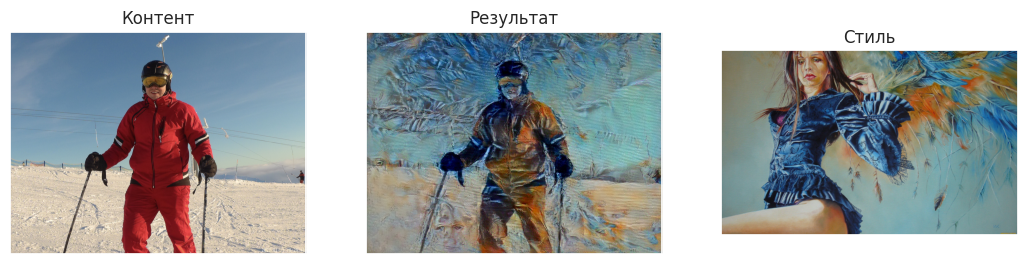

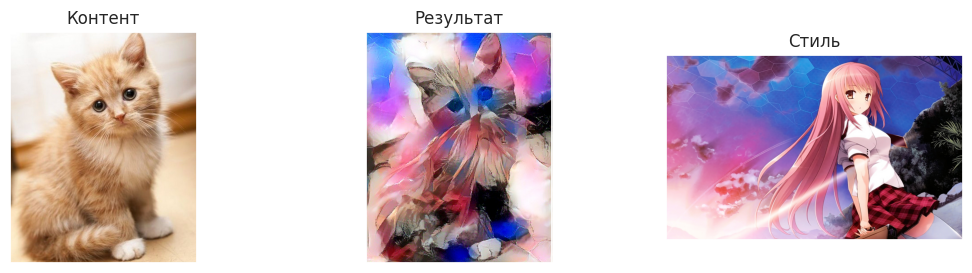

In [39]:
# Сохраним результаты
#!cp -r data/output-images /drive/MyDrive/result

# Визуализируем
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

In [40]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.3 MB/s eta 0:00:00


In [1]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

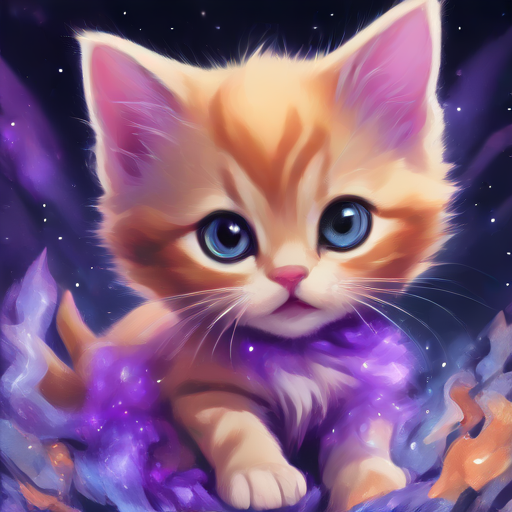

In [2]:
prompt = "Cute ginger kitten in anime style blue purple explosion"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

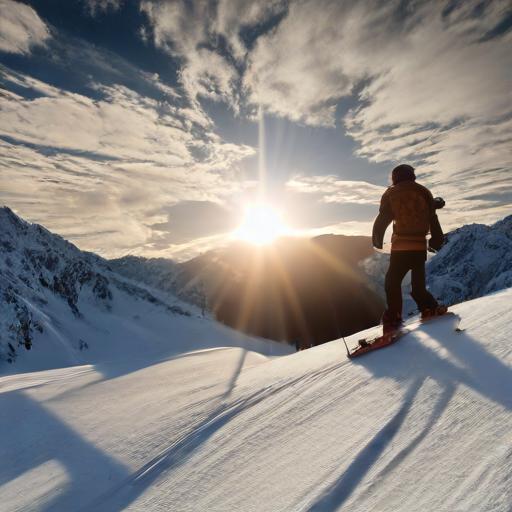

In [3]:
prompt = "2 skiers on the slope of a ski resort against the background of the sun and clouds, where the clouds are below the peak of the mountain in a kaleidoscope style"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

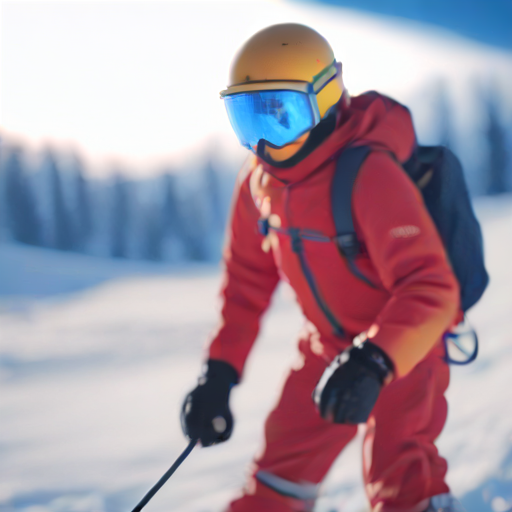

In [4]:
prompt = "A skier with poles in a red jumpsuit and ski mask and helmet on a white field background in the style of a blue-yellow blur"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

**Вывод:**
* Мы можем видеть, что первая нейросеть работает достаточно эффективно, в целом выдавая желаемый результат, но чтобы получить действительно, то что хотели изображение style должно иметь ярко выраженный стиль и не иметь выраженного содержания.
* Нейросеть, генерирующая изображение по тексту выдаёт посредственный результат: вероятно, это связано с необходимостью составлять сложные запросы, а так же данная нейросеть не смогла придать изображению вообще никакой стиль
* Данные нейросети практически не обучаются без gpu